## 0. Import Required Libraries  
We start by importing the necessary libraries for data handling, preprocessing, visualization, and model building.  
- **pandas/numpy** → Data manipulation  
- **matplotlib/seaborn** → Visualization  
- **scikit-learn** → Regression models, preprocessing, and evaluation  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# For pretty plots
sns.set(style="whitegrid")

## 1. Load Dataset  
We load the Boston Housing dataset, which contains features such as crime rate, average number of rooms per dwelling, property tax rate, and other socio-economic indicators.  
Our goal is to predict the **median house price (MEDV)** based on these features.  


In [2]:
df = pd.read_csv("HousingData.csv")

print("\n--- Initial Dataset Info ---")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())


--- Initial Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None

Missing Values:
 CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20


## 3. Data Preprocessing – Missing Values & Outliers  
- Identify and handle any missing values in the dataset.  
- Detect outliers using statistical methods (IQR/boxplots).  
- Apply transformations or capping to reduce the effect of extreme values.  
##  Feature Engineering  
We prepare the dataset for modeling:  
- Normalize or standardize numerical features.  
- Generate correlation heatmaps to drop irrelevant or highly collinear features.  
- Ensure the target variable (house price) is properly scaled if required.  



Dataset shape after outlier removal: (222, 14)


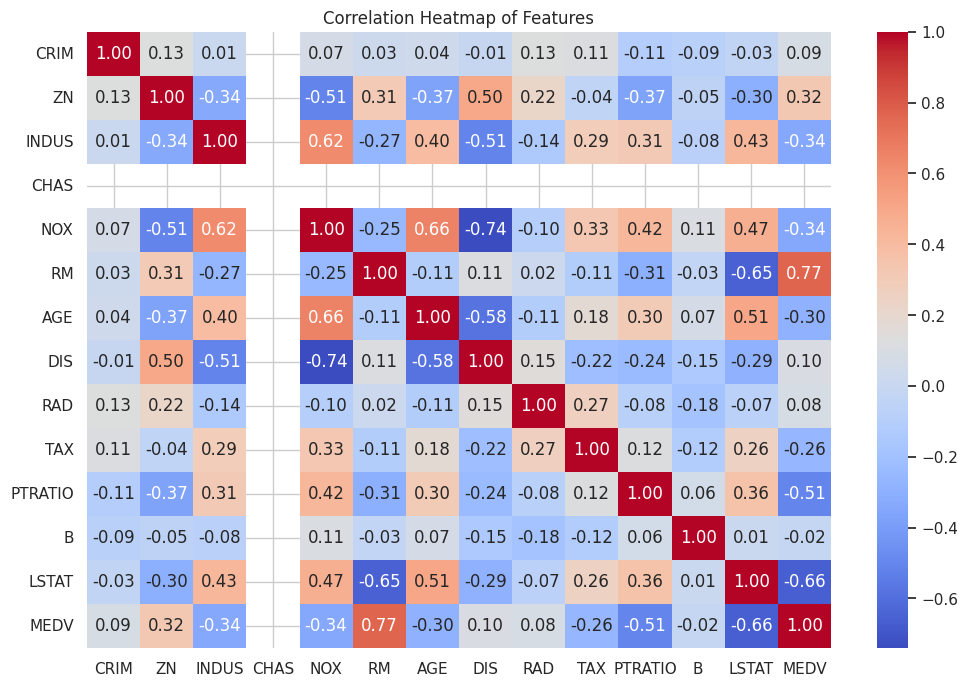

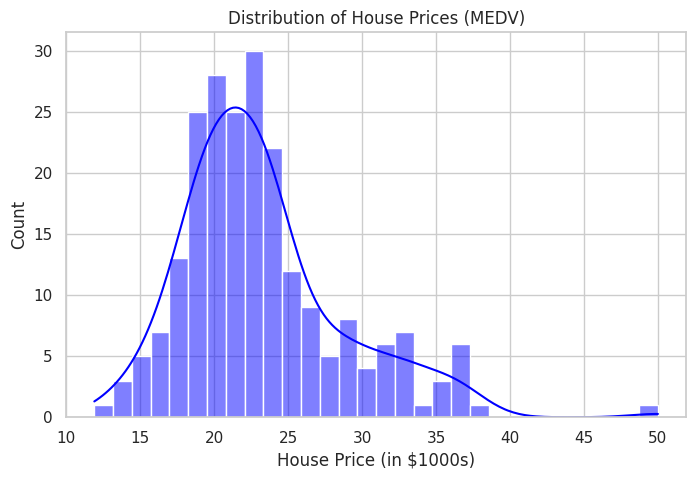

In [3]:
df.fillna(df.mean(numeric_only=True), inplace=True)

# ---- Outlier Handling (IQR Method) ----
def remove_outliers_iqr(data, columns):
    cleaned_data = data.copy()
    for col in columns:
        Q1 = cleaned_data[col].quantile(0.25)
        Q3 = cleaned_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]
    return cleaned_data

numeric_cols = df.drop(columns=["MEDV"]).select_dtypes(include=[np.number]).columns
df = remove_outliers_iqr(df, numeric_cols)

print("\nDataset shape after outlier removal:", df.shape)

# ---- Visualization: Correlation Heatmap ----
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

# ---- Visualization: Distribution of Target (MEDV) ----
plt.figure(figsize=(8,5))
sns.histplot(df["MEDV"], kde=True, bins=30, color="blue")
plt.title("Distribution of House Prices (MEDV)")
plt.xlabel("House Price (in $1000s)")
plt.show()

# Features & Target
X = df.drop(columns=["MEDV"])
y = df["MEDV"]


## 5. Train-Test Split  
The dataset is split into **training** and **testing** subsets using `train_test_split`.  
- Training data → Used to fit the regression model  
- Test data → Used to evaluate generalization performance  


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Model Training – Linear Regression  
We begin with a **Linear Regression model** as the baseline.  
Linear regression assumes a linear relationship between features and the target variable.  
##  Model Training – Decision Tree & Gradient Boosting  
To improve performance, we also experiment with advanced regression models:  
- **Decision Tree Regressor** → Captures non-linear relationships.  
- **Gradient Boosting Regressor** → Uses an ensemble of weak learners to improve accuracy.  


In [6]:
# --- Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

# --- Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# --- Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --- XGBoost Regressor
xgb = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

## 7. Model Evaluation  
We evaluate model performance using metrics such as:  
- **Mean Squared Error (MSE)** → Measures average squared prediction errors  
- **R² Score** → Explains the proportion of variance captured by the model  
Lower MSE and higher R² indicate better performance.  


Linear Regression Performance:
  RMSE: 3.751
  R² Score: 0.685

Gradient Boosting Performance:
  RMSE: 3.690
  R² Score: 0.695

Random Forest Performance:
  RMSE: 4.191
  R² Score: 0.607

XGBoost Performance:
  RMSE: 4.128
  R² Score: 0.619



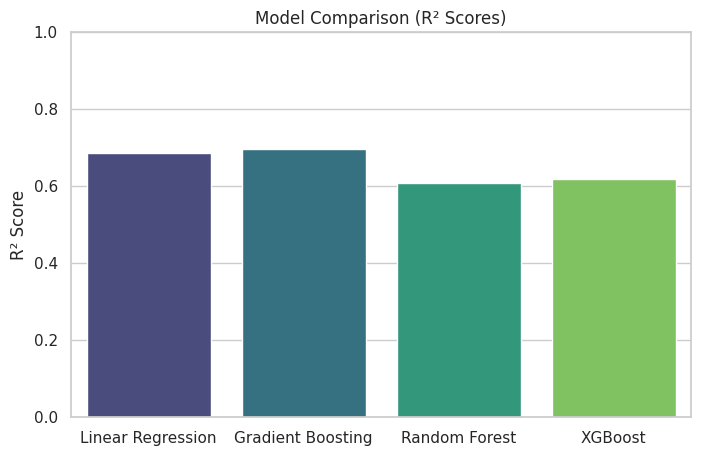

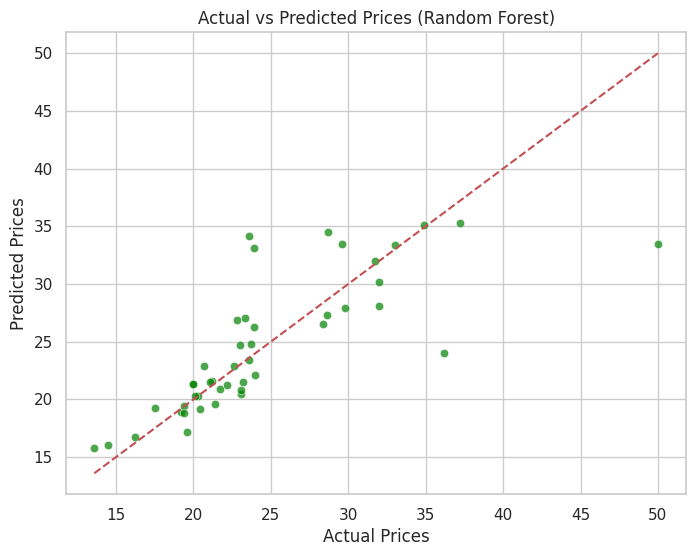

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R² Score: {r2:.3f}\n")
    return rmse, r2

results = {}
results["Linear Regression"] = evaluate_model(y_test, y_pred_lin, "Linear Regression")
results["Gradient Boosting"] = evaluate_model(y_test, y_pred_gbr, "Gradient Boosting")
results["Random Forest"] = evaluate_model(y_test, y_pred_rf, "Random Forest")
results["XGBoost"] = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# ---- Visualization: Model Comparison ----
plt.figure(figsize=(8,5))
model_names = list(results.keys())
r2_scores = [results[m][1] for m in model_names]
sns.barplot(x=model_names, y=r2_scores, palette="viridis")
plt.title("Model Comparison (R² Scores)")
plt.ylabel("R² Score")
plt.ylim(0,1)
plt.show()

# ---- Visualization: Actual vs Predicted (for best model, say Random Forest) ----
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # ideal line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (Random Forest)")
plt.show()


## 8. Model Fine-Tuning  
Hyperparameter tuning is applied (e.g., max depth in Decision Tree, learning rate in Gradient Boosting) to improve prediction accuracy.  
Grid Search or Randomized Search may be used for optimization.  


In [8]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="r2")
print("Random Forest CV Mean R²:", cv_scores.mean())

Random Forest CV Mean R²: 0.452997657613568


## 9. Final Observations  
- The baseline **Linear Regression** provides a quick benchmark.  
- **Decision Tree** captures non-linearities but may overfit.  
- **Gradient Boosting** usually offers the best balance of bias and variance.  
This modeling pipeline can help in real estate decision-making by predicting housing prices accurately.  



Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Tuned Random Forest Performance:
  RMSE: 4.191
  R² Score: 0.607



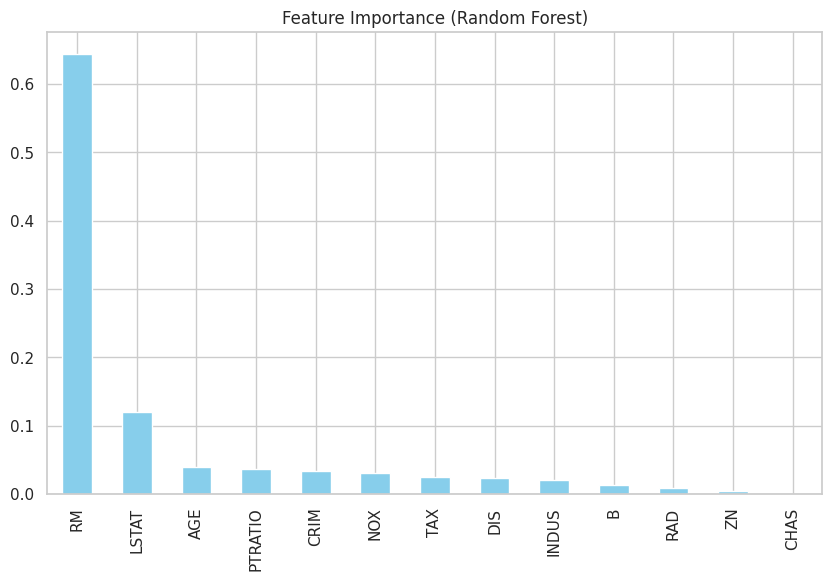

In [9]:
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10]
}
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=5, cv=5, scoring="r2", n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("\nBest Parameters for Random Forest:", random_search.best_params_)
best_rf = random_search.best_estimator_

# Final evaluation
y_pred_best = best_rf.predict(X_test)
evaluate_model(y_test, y_pred_best, "Tuned Random Forest")

# ---- Visualization: Feature Importance (Random Forest) ----
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
plt.figure(figsize=(10,6))
feat_importances.sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Feature Importance (Random Forest)")
plt.show()